### 0. Import modules

In [6]:
import os
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
    TexturesUV,
    Textures
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

In [9]:
from utils.plot_image_grid import image_grid

<function image_grid at 0x000001AF1C99BF60>


### 1. Load and normalize image dataset 

set up device

In [16]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(f"It's going to use {device}")

It's going to use cuda:0


Load images to preview and normalize them

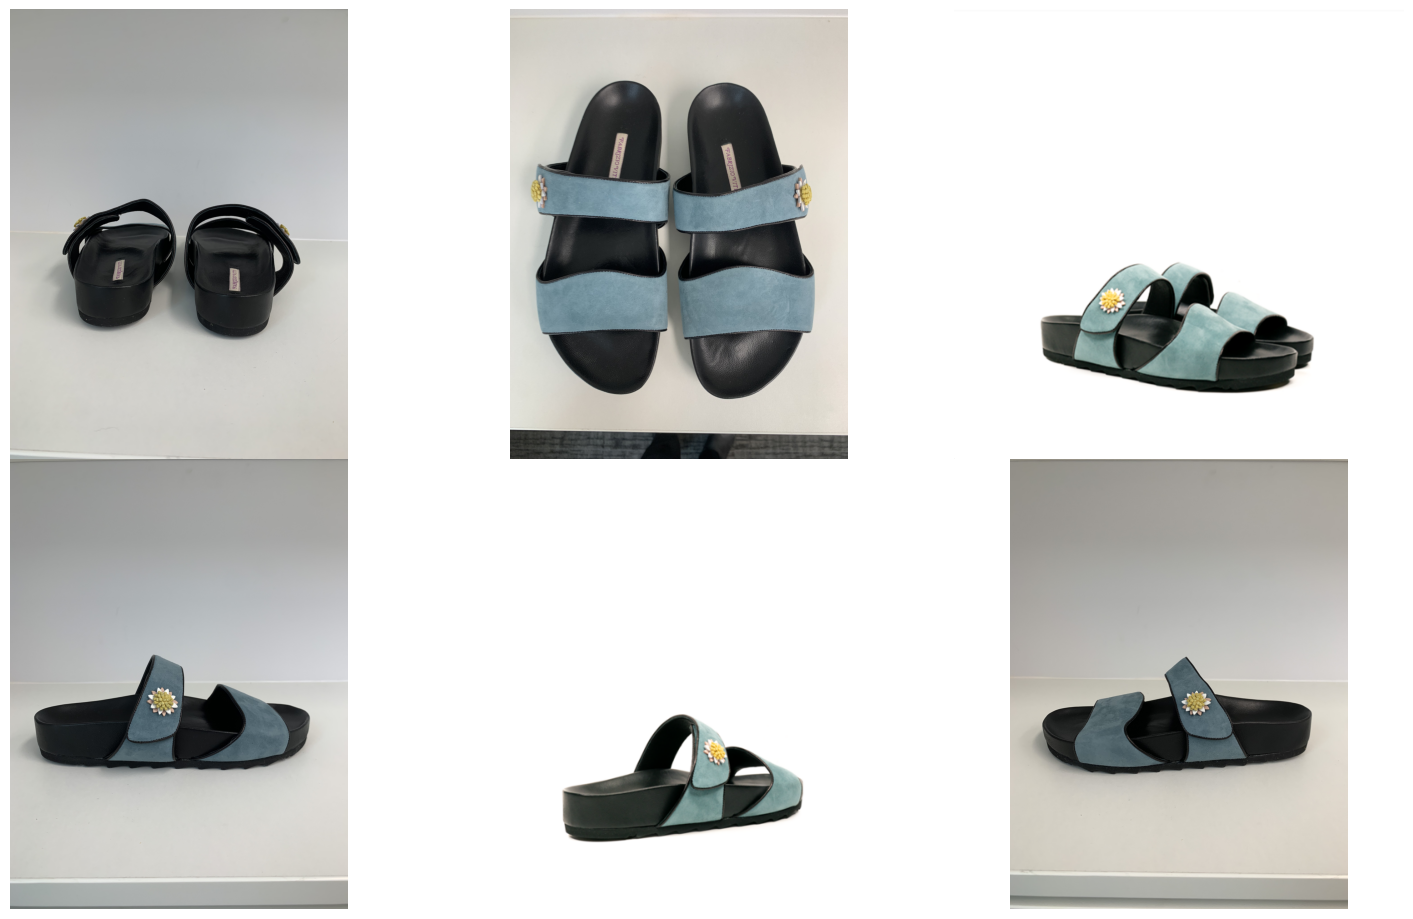

Size of the Image tensor: torch.Size([6, 3, 224, 224])


In [20]:
DATA_DIR = "./images"
img_filenames = os.listdir(DATA_DIR)

# preview images
images_for_preview = []
for filename in img_filenames:
    images_for_preview.append(Image.open(os.path.join(DATA_DIR, filename)))

preview_images = [np.array(image) for image in images_for_preview]
image_grid(preview_images, rows=2, cols=3)
plt.show()

# convert images to PyTorch tensors
image_tensors = []
for filename in img_filenames:
    image = Image.open(os.path.join(DATA_DIR, filename)).convert("RGB")
    transform = T.Compose([T.Resize((224, 224)), T.ToTensor()])
    image = transform(image)
    image_tensors.append(image)
image_tensors = torch.stack(image_tensors)

# print(f"Image tensor: {image_tensors}")
print(f"Size of the Image tensor: {image_tensors.size()}")


### 2. Turn image tensors to 3D mesh related information

create a texture from images

In [23]:
from pytorch3d.renderer import TexturesUV

# Move tensor to CPU
image_tensors = image_tensors.cpu()

# Transpose the tensor
texture_image = torch.transpose(image_tensors, 1, 2)
texture_image = torch.transpose(texture_image, 1, 3)

# Create the faces_uvs tensor
num_faces = len(image_tensors) * 2 * (224-1) * (224-1)
faces_uvs = torch.arange(0, num_faces * 3).reshape(1, -1, 3)

# Create the verts_uvs tensor
verts_uvs = torch.tensor([[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]])
verts_uvs = verts_uvs.repeat(image_tensors.shape[0], 1, 1)

# Create a texture map from the image tensor
texture_map = TexturesUV(maps=texture_image, faces_uvs=faces_uvs, verts_uvs=verts_uvs)

# Convert the texture map to a numpy array
texture_map_np = texture_map.maps_padded().detach().cpu().numpy()

# Plot the texture map
fig, axs = plt.subplots(1, 6, figsize=(15, 15))
for i in range(6):
    axs[i].imshow(np.transpose(texture_map_np[i], (1, 2, 0)))
    axs[i].axis("off")
plt.show()

ValueError: Expected verts_uvs to be of shape (N, V, 2); got 'torch.Size([6, 4, 2])'

In [ ]:
from pytorch3d.ops import cubify


# Reconstruct 3D mesh from 2D images
mesh = cubify(image_tensors, thresh=0.5)

# Create a texture map from the image tensor
texture_image = image_tensors.permute(1, 2, 0).unsqueeze(0).cpu()
texture_map = TexturesUV(maps=texture_image)


# Move mesh to device
mesh = mesh.to(device)

In [ ]:
# the number of different viewpoints from which we want to render the mesh.
num_views = len(image_tensors)
print(f"num_views : {num_views}")

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Place a point light in front of the object.
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

In [ ]:
textures=Textures(
            maps=image_tensors.to(device),
            coords=mesh.textures.coords_packed(),
        )


# Define renderer
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
    bin_size=0,
)
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=cameras,
        lights=lights,
        textures=textures
    ),
)

In [ ]:
print(mesh.device)
print(cameras.device)
print(lights.device)


In [ ]:
# Render mesh
image = renderer(mesh)

# Save reconstructed mesh to file
save_obj("./predicted_mesh.obj", mesh)